In [53]:
import numpy as np
import matplotlib.pyplot as plt
from json import loads, dumps
from scipy.io import loadmat,savemat
from scipy import sparse
from jpype import *
import os
import scipy.io as spio
from JITDWrapper import *
from ipywidgets import interact,interact_manual,IntSlider

#Custom Loadmat
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict
    

#Custom Raster Loader
def dataLoader(exp,cond,tbase):
    rasterfile = "../Data/Sparse/E{0}_C{1}_T{2}".format(exp,cond,tbase)
    if os.path.isfile(rasterfile+".npz"):
        print("Returning saved sparse matrix",rasterfile.split("/")[-1])
        raster = sparse.load_npz(rasterfile+".npz")
        raster = raster.toarray()
        return raster,raster.shape[0]
    data = loadmat(FILENAME)["spks"][exp][cond][0]
    Ncount = data.shape[0] #neuron count
    maxdata = max([max(data[n][0]) for n in range(Ncount)])+1 #max spike time of sample
    raster=np.zeros((Ncount,int(maxdata/tbase)))  #raster dimensions
    for n in range(Ncount):
        for s in data[n][0]:
            if not np.isnan(s):
                raster[n][int(s/tbase)]=1 #binarizing [0,TBIN[ and so on
    print ("Saving sparse matrix")
    sparse.save_npz(rasterfile,sparse.csr_matrix(raster))
    return raster,Ncount

def fishLoader():
    data = loadmat("../Data/Fishmovie/IST-2017-61-v1+1_bint_fishmovie32_100.mat")["bint"]
    stacked = np.hstack([data[i,:,:] for i in range(297)])
    return stacked,stacked.shape[0]

def ratcheckLoader():
    data = loadmat("../Data/2014_01_28_check_AND_fullfield.mat")
    stacked = np.hstack([data["binnedCheckerboard"][:,:,n] for n in range(79)])
    return stacked,stacked.shape[0]

def ratfieldLoader():
    data = loadmat("../Data/2014_01_28_check_AND_fullfield.mat")
    stacked = np.hstack([data["binnedFullfield"][:,:,n] for n in range(65)])
    return stacked,stacked.shape[0]

def degus2loader():
    start,end = 2669.8345, 3302.4556
    data =loadmat("../Data/MR-0227/spk_20180105.mat")["spk_times"]/20000 #segundos
    raster = np.zeros((len(data),int((end-start)+1)*50)) #3302-2669 es segundo de fin de pelicula natural
    for n in range(raster.shape[0]):
        for t in data[n]:
            if start < t and t < end:
                raster[n,int((t-start)/0.02)] = 1
    raster = raster[:,:-3]
    samps = 21
    singleraster = np.sum(np.split(raster,samps,axis=1),axis=0)/samps
    return raster,raster.shape[0],singleraster,samps


def rasterMutualInformation(raster,filename):
    mifile="../Data/PreComputed/MI/{}".format(filename)
    if os.path.isfile(mifile+".npy"):
        print ("Returning PreComputed MIMatrix "+mifile.split("/")[-1])
        return np.load(mifile+".npy")
    Ncount = raster.shape[0]
    calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
    calc = calcClass(2, 2, 0)
    MI = np.zeros((Ncount,Ncount))
    for S in range(Ncount):
        source = JArray(JInt, 1)(raster[S].tolist())
        for D in range(S,Ncount):
            if S==D: continue;
            destination = JArray(JInt, 1)(raster[D].tolist())
            calc.initialise()
            calc.addObservations(source, destination)
            MI[S][D]=calc.computeAverageLocalOfObservations()
        print(S," ",end="")
    np.save(mifile,MI)
    return MI


In [12]:
data =loadmat("../Data/MR-0227/spk_20180105.mat")["spk_times"]/20000

In [47]:
a,b = degus2loader()

In [71]:
a[:,:-3].shape[1]/(30.14*50)

21.0

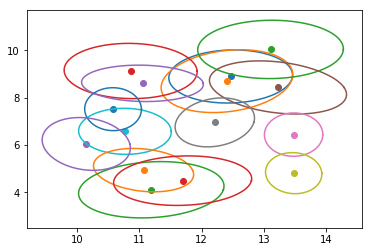

In [146]:
for i in range(15):
    plt.plot(ratfile["Xell"][:,ratfile["ALL"]-1][:,i],ratfile["Yell"][:,ratfile["ALL"]-1][:,i])
    plt.scatter(Xcenters[i],Ycenters[i])

In [68]:
Xcenters = np.mean(ratfile["Xell"][:,ratfile["ALL"]-1],axis=0)
Ycenters = np.mean(ratfile["Yell"][:,ratfile["ALL"]-1],axis=0)
RFCenters = np.array(list(zip(Xcenters,Ycenters)))

Returning PreComputed MIMatrix degus2


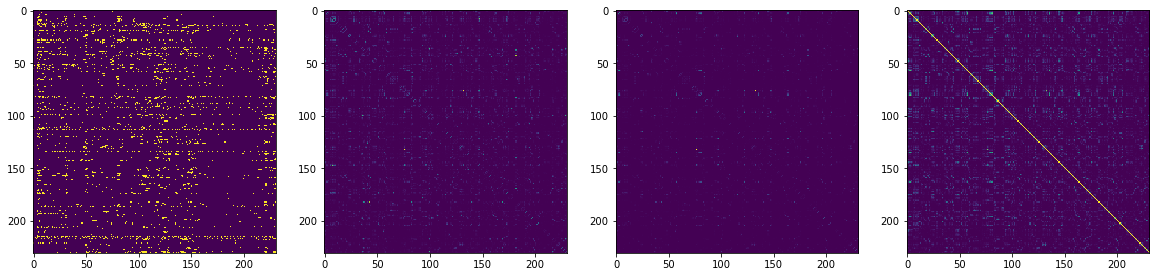

In [55]:
RASTER,N,SINGLERASTER,SAMPS = degus2loader()#dataLoader(0,3,0.02)
SPRATE = (np.array([np.sum(RASTER[:,i:i+50],axis=1) for i in range(0,RASTER.shape[1]-50)])/50).T
BASE = "degus2"
#reRASTER = loadmat("../Data/Fishmovie/IST-2017-61-v1+1_bint_fishmovie32_100.mat")["bint"]
#SINGLERASTER = np.sum(np.split(RASTER,65,axis=1),axis=0)/65
#D = loadmat("../Data/rfOverlap.mat")["rfDist"][0]#[0]
MI = rasterMutualInformation(RASTER,BASE) #MutualInformation(0,3,0.02)
MI = MI+MI.T
CC = np.corrcoef(RASTER[:50],RASTER[50:])**2-np.diag(np.ones(N))
permuts = [np.random.choice(list(range(SAMPS)),SAMPS,replace=False) for n in range(N)] #n,297 permuts
#D = [[np.linalg.norm(RFCenters[j] - RFCenters[i]) for j in range(N)] for i in range(N)]
#for x in range(N):
#    for y in range(N):
#        D[x][y]= np.sum(np.abs(SINGLERASTER[x]/50-SINGLERASTER[y]/50))
        
Dcc = np.zeros((N,N))
for x in range(N):
    for y in range(N):
        Dcc[x][y]= np.corrcoef(SINGLERASTER[x],SINGLERASTER[y])[0,1]**2
D=Dcc
#Basic plotting
f,ax = plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(RASTER[:,:N])
ax[1].imshow(MI)
ax[2].imshow(CC)
ax[3].imshow(D)
plt.show()



#Específico
#NsR = [10,15,20,25,30,50]#,100,120,150]
#Ns = [4,5,6,7,8,9,10,15,20,25,30,50]#,100,120,150]
NsR = [10,15,20,25]#,100,120,150]
Ns = [4,5,6,7,8,9,10,15,20,25]#,100,120,150]

#MaxentPart
MAXENTFOLDER = "Ising/"
RASTERSFOLDER = "dRasters/"
MODELSFOLDER = "dModels/"


#Results
PREDICTIONSFOLDER = "dPredictions/"
PREDPSTHFOLDER = "dpredPSTH/"
MEASURESFOLDER = "dMeasures/"
MEASURESPSTHFOLDER = "dMeasuresPSTH/"
DATASETSFOLDER = "dFileDatasets/"


In [88]:
reRASTER.shape

(297, 160, 953)

In [75]:
SINGLERASTER.shape

(231, 1507)

# Redundancy-matlab summary

## Degus/case specific

* Dataset maker (raster,target) -> saves dataset file and returns dataset dict
* Filename maker (dataset item)
* Async launcher(modelfilenames)
* JITD wrapper ftm but generalize it
* Mutual info (raster,savefilename) -> saves filename of MI
* Corref (raster,savefilename) -> same
* RF -> Absolute load.

## Maxent zone + file checks
* Raster maker (raster,target,units,savefilename) -> saves raster
* Adjust launcher (rastername,modelname, execparams) -> saves model
* Prediction (raster,target,modelname,predictionfile) -> saves prediction
* Measures (raster,target,predicitonfile,measuresfile) -> returns measures & saves file


## General

In [63]:
def filenameMkr(n,r,f,s,base="E0C3T0.02",p=0):
    """
    n = target neuron, r=rank type, p=part, f=fixed neurons, s=sample number 
    base = ECT part
    """
    return "{0}N{1}R{2}P{3}F{4}S{5}".format(base,n,r,p,f,s)

def datasetMaker(target,base="E0C3T0.02"):
    #Si ya existe
    if "N{0}.json".format(target) in os.listdir(DATASETSFOLDER):
        with open("{}/N{}.json".format(DATASETSFOLDER,target)) as DD:
            filedataset = loads(DD.readline())
        print("Carga de archivo existente para neurona {0}".format(target))

    #Si no existe
    else:
        free = np.array(list(set(range(N))-{target}))
        mienum = sorted([(x[1],x[0]) for x in enumerate(MI[target])],reverse=1) #mayor a menor
        miids = list([x[1] for x in mienum])
        miids.remove(target)
        cenum = sorted([(x[1],x[0]) for x in enumerate(CC[target])],reverse=1)
        cids = list([x[1] for x in cenum])[:-1]
        denum = sorted([(x[1],x[0]) for x in enumerate(D[target])])
        dids = list([x[1] for x in denum])[1:]
        
        dataset = {"target":target,
                   0:dict([(n,[sorted(np.random.choice(free,n,False).tolist()) for j in range(5)]) for n in NsR]),
                   1:{},
                   2:dict([(n,[miids[:n]]) for n in Ns]),
                   3:dict([(n,[dids[:n]]) for n in Ns]),
                   4:dict([(n,[cids[:n]]) for n in Ns])} 
        newsets=[np.random.choice(list(set(range(N))-{target}),N-1,False).tolist() for j in range(5)]
        for n in NsR:
            dataset[1][n]=[]
            for j in range(5):
                dataset[1][n].append(newsets[j][:n])
        filedataset= {}
        for r in [0,1]:
            for f in NsR:
                for s in range(5):
                    filedataset[filenameMkr(target,r,f,s,base)] = dataset[r][f][s]
        for r in [2,3,4]:
            for f in Ns:
                filedataset[filenameMkr(target,r,f,0,base)] = dataset[r][f][0]
                
        with open("{}/N{}.json".format(DATASETSFOLDER,target),"w") as DD:
            DD.write(dumps(filedataset))
    return filedataset

def saveRaster(filename,selected,force=0):
    if filename+".mat" in os.listdir(MAXENTFOLDER+RASTERSFOLDER) and not force:
        return
    print(RASTER[selected].shape)
    savemat("{}{}{}.mat".format(MAXENTFOLDER,RASTERSFOLDER,filename),{"binnedSpikes":RASTER[selected]})


In [64]:
def updateDataset(target,base="E0C3T0.02"):
    with open("{}/N{}.json".format(DATASETSFOLDER,target)) as DD:
        filedataset = loads(DD.readline())
        #print("Carga de archivo existente para neurona {0}".format(target))
        denum = sorted([(x[1],x[0]) for x in enumerate(D[target])])
        dids = list([x[1] for x in denum])[1:]
        #print(dids[:10])
        dataset = {3:dict([(n,[dids[:n]]) for n in Ns])}
        for f in Ns:
            filedataset[filenameMkr(target,3,f,0,base)] = dataset[3][f][0]
            #print(dataset[3][f][0])
    with open("{}/N{}.json".format(DATASETSFOLDER,target),"w") as DF:
            DF.write(dumps(filedataset))

def updateDataset2(target,base="E0C3T0.02"):
    with open("{}N{}.json".format(DATASETSFOLDER,target)) as DD:
        filedataset = loads(DD.readline())
        #print("Carga de archivo existente para neurona {0}".format(target))
        denum = sorted([(x[1],x[0]) for x in enumerate(Dcc[target])],reverse=1)
        dids = list([x[1] for x in denum])[1:]
        #print(dids[:10])
        dataset = {5:dict([(n,[dids[:n]]) for n in Ns])}
        for f in Ns:
            filedataset[filenameMkr(target,5,f,0,base)] = dataset[5][f][0]
            #print(dataset[3][f][0])
    with open("{}N{}.json".format(DATASETSFOLDER,target),"w") as DF:
            DF.write(dumps(filedataset))

            
def overwriteDataset(target,newdata,base="E0C3T0.02"):
    with open("{}/N{}.json".format(DATASETSFOLDER,target),"w") as DF:
            DF.write(dumps(newdata))
   
for n in ordenadas:
    datasetMaker(n,BASE)
    updateDataset2(n,BASE)

In [61]:
def runMatlab(filename,etah=0.0,etaj=0.0,run=1,force=0):
    if (filename+".mat" in os.listdir(MAXENTFOLDER+MODELSFOLDER)) and not force:
        return
    line = """matlab -nodisplay -nosplash -nodesktop -r "cd('{}');Ajustar_params('{}','{}','{}.mat',{},{});exit()" """.format(MAXENTFOLDER,RASTERSFOLDER,MODELSFOLDER,filename,etah,etaj)
    if run:
        os.system(line)
    else:
        print(line)

def loadParams(modelfile):
    data = loadmat(MAXENTFOLDER+MODELSFOLDER+modelfile+".mat")
    params = data["params"]
    N = len(data["hListIn"])
    P = np.zeros((N,N))
    P[np.triu_indices(N, 1)] = params[N:] 
    P = P+np.diag(params[:N])
    return P


def modelView(modelfile,plot=0):
    data = loadmat(MAXENTFOLDER+MODELSFOLDER+modelfile+".mat")
    p,q,ccdata,ccmodel,params = data["p"],data["q"],data["ccData"],data["ccModel"],data["params"]
    c1,c2 = np.corrcoef(p,q)[1,0], np.corrcoef(ccdata,ccmodel)[1,0]
    c1 = np.round(c1,3)
    c2 = np.round(c2,3)
    #plot
    if plot:
        f,ax = plt.subplots(1,4,figsize=(21,2))
        f.suptitle(modelfile)
        n=len(ccdata)-len(p)
        ax[0].hist(params[:n]);ax[0].title.set_text('h coef')
        ax[1].hist(params[n:],bins=50);ax[1].title.set_text('j coef')
        ax[2].scatter(p,q);ax[2].title.set_text('Mean Rate Data/Model CC: {} '.format(c1))
        ax[3].scatter(ccdata,ccmodel);ax[3].title.set_text('Covariances Data/Model CC: {}'.format(c2))
        plt.show()
    return data,c1,c2

def modelCheck(modelfile):
    _,c1,c2 = modelView(modelfile,0)
    if c2>0.5 and c1>0.5:
        return True
    for h in [0.05]:
        for j in [0.05]:
            print("Trying {} {}".format(h,j))
            runMatlab(modelfile,etah=h,etaj=j,run=1,force=1)
            _,c1,c2 = modelView(modelfile,0)
            if c2>0.5 and c1>0.5:
                return True
    
    
def predict(raster,params,filename,T,overwrite=0):
    try:
        obtRate = np.load(PREDICTIONSFOLDER+filename+".npy")
        if not overwrite:
            return obtRate
    except:
        pass
    obtRate = []
    for t in range(T):
        selected = np.array([[1.0]+raster.T[t][1:N].tolist(), [0.0]+raster.T[t][1:N].tolist()]) # 1/0 + data 1:N
        prob_denom = np.sum(np.exp(np.sum(np.matmul(selected,params)*selected,1))) #Prob P(given)
        selected = np.array([[1.0]+raster.T[t][1:N].tolist()]) #1 + data 1:N
        prob_num = np.sum(np.exp(np.sum(np.matmul(selected,params)*selected,1))) #Prob P(target,given)
        obtRate.append(prob_num/prob_denom)
    obtRate = np.array([np.sum(obtRate[i:i+50]) for i in range(0,len(obtRate)-50)])/50
    np.save(PREDICTIONSFOLDER+filename,obtRate)
    return obtRate


#REFUNDIR
def predictPSTH(raster,params,filename,T,overwrite=0):
    try:
        obtRate = np.load(PREDPSTHFOLDER+filename+".npy")
        if not overwrite:
            return obtRate
    except:
        pass
    obtRate = []
    for t in range(T):
        selected = np.array([[1.0]+raster.T[t][1:N].tolist(), [0.0]+raster.T[t][1:N].tolist()]) # 1/0 + data 1:N
        prob_denom = np.sum(np.exp(np.sum(np.matmul(selected,params)*selected,1))) #Prob P(given)
        selected = np.array([[1.0]+raster.T[t][1:N].tolist()]) #1 + data 1:N
        prob_num = np.sum(np.exp(np.sum(np.matmul(selected,params)*selected,1))) #Prob P(target,given)
        obtRate.append(prob_num/prob_denom)
    obtRate = np.array(obtRate)
    print(obtRate.shape)
    obtRate = np.sum(obtRate.reshape((SAMPS,-1)),axis=0)
    print(obtRate.shape)
    np.save(PREDPSTHFOLDER+filename,obtRate)
    return obtRate

#permut+psth
def predictPSTHperm(raster,params,filename,T,overwrite=0):
    try:
        obtRate = np.load(PREDPSTHFOLDER+filename+"S.npy")
        if not overwrite:
            return obtRate
    except:
        pass
    obtRate = []
    subN = raster.shape[0]
    print(subN)
    for t in range(T):
        t = t%1507 #time of repetition
        rep = int(t//1507)
        fixed = [raster.T[t+permuts[n][rep]*1507][n] for n in range(1,subN)]#raster.T[t][1:N].tolist()
        selected = np.array([[1.0]+fixed, [0.0]+fixed]) # 1/0 + data 1:N
        prob_denom = np.sum(np.exp(np.sum(np.matmul(selected,params)*selected,1))) #Prob P(given)
        selected = np.array([[1.0]+fixed]) #1 + data 1:N
        prob_num = np.sum(np.exp(np.sum(np.matmul(selected,params)*selected,1))) #Prob P(target,given)
        obtRate.append(prob_num/prob_denom)
    obtRate = np.array(obtRate)
    print(obtRate.shape)
    obtRate = np.sum(obtRate.reshape((SAMPS,-1)),axis=0)
    print(obtRate.shape)
    np.save(PREDPSTHFOLDER+filename+"S",obtRate)
    return obtRate



def getPrediction(filename):
    obtRate = np.load(PREDICTIONSFOLDER+filename+".npy")
    return obtRate

def getPSTH(filename):
    obtRate = np.load(PREDPSTHFOLDER+filename+".npy")
    return obtRate

    
#Measures

def computeMeasures(target,filename,overwrite=0):
    try:
        if not overwrite:
            r2 = np.load(MEASURESFOLDER+filename+".npy")
    except:
        pass
    r2 = np.corrcoef(SPRATE[target],getPrediction(filename))[0,1]**2
    np.save(MEASURESFOLDER+filename,r2)
    return r2

#Measures2

def computeMeasuresPSTH(target,filename,overwrite=0):
    try:
        if not overwrite:
            r2 = np.load(MEASURESPSTHFOLDER+filename+".npy")
            return r2
    except:
        pass
    r2 = np.corrcoef(SINGLERASTER[target],getPSTH(filename))[0,1]**2
    np.save(MEASURESPSTHFOLDER+filename,r2)
    return r2


In [57]:
SINGLERASTER.shape

(231, 1507)

In [60]:
#PLOTS

def showPrediction(target,filename):
    plt.figure(figsize=(21,2))
    plt.title(filename+" $R^2$: "+str(np.round(computeMeasures(target,filename),3)))
    plt.plot(SPRATE[target][:1500])
    plt.plot(getPrediction(filename)[:1500])
    plt.show()
    
def showPredictionPSTH(target,filename):
    plt.figure(figsize=(21,2))
    plt.title(filename+" $R^2$: "+str(np.round(computeMeasuresPSTH(target,filename),3)))
    plt.plot(range(len(SINGLERASTER[target])),SINGLERASTER[target])
    plt.plot(range(len(SINGLERASTER[target])),getPSTH(filename)/297)
    plt.show()
    
def plotr2(target):
    rand = np.array([np.array([computeMeasures(target,filenameMkr(target,0,f,s,BASE)) for f in NsR]) for s in range(5)])
    meanrand = np.mean(rand,axis=0)
    stdrand = np.std(rand,axis=0)
    mi = np.array([computeMeasures(target,filenameMkr(target,2,f,0,BASE)) for f in Ns])
    plt.plot(NsR,meanrand,label="Random")
    plt.fill_between(NsR,meanrand-stdrand,meanrand+stdrand,alpha=0.1)
    plt.plot(Ns,mi,label="MI")
    plt.title("N = {}".format(target))
    plt.legend()
    plt.show()
    
    
#overallplot

def overallR2(nlist,thr):
    badmods = checkCorrect(ordenadas,thr)
    rand = {}
    std = {}
    rand2 = {}
    std2 = {}
    mi = {}
    psth = {} #psth ranking with sprate
    psth2 = {} #psth rank with psth r2
    psth3 = {} #psth rank with 
    stdpsth2 = {}
    stdpsth3 = {}
    #for nn in Ns:
    #    mi[nn]=np.mean([computeMeasures(target,filenameMkr(target,2,nn,0,BASE)) for target in nlist if filenameMkr(target,2,nn,0,BASE) not in badmods[target]])
    #for nn in Ns:
    #    psth[nn]=np.mean([computeMeasures(target,filenameMkr(target,3,nn,0,BASE)) for target in nlist if filenameMkr(target,3,nn,0,BASE) not in badmods[target]])
    for nn in Ns:
        psth2[nn]=np.mean([computeMeasuresPSTH(target,filenameMkr(target,5,nn,0,BASE)) for target in nlist if filenameMkr(target,5,nn,0,BASE) not in badmods[target]])
        psth3[nn]=np.mean([computeMeasuresPSTH(target,filenameMkr(target,5,nn,0,BASE)+"S") for target in nlist if (filenameMkr(target,5,nn,0,BASE)+"S") not in badmods[target]])
        stdpsth2[nn]=np.std([computeMeasuresPSTH(target,filenameMkr(target,5,nn,0,BASE)) for target in nlist if filenameMkr(target,5,nn,0,BASE) not in badmods[target]])
        stdpsth3[nn]=np.std([computeMeasuresPSTH(target,filenameMkr(target,5,nn,0,BASE)+"S") for target in nlist if (filenameMkr(target,5,nn,0,BASE)+"S") not in badmods[target]])
    for nn in NsR:
        rand[nn]=np.mean([np.mean([computeMeasuresPSTH(target,filenameMkr(target,0,nn,ss,BASE)) for ss in range(5) if filenameMkr(target,0,nn,ss,BASE) not in badmods[target] ]) for target in nlist])
        std[nn]=np.std([np.mean([computeMeasuresPSTH(target,filenameMkr(target,0,nn,ss,BASE)) for ss in range(5) if filenameMkr(target,0,nn,ss,BASE) not in badmods[target] ]) for target in nlist])
        rand2[nn]=np.mean([np.mean([computeMeasuresPSTH(target,filenameMkr(target,0,nn,ss,BASE)+"S") for ss in range(5) if filenameMkr(target,0,nn,ss,BASE)+"S" not in badmods[target] ]) for target in nlist])
        std2[nn]=np.std([np.mean([computeMeasuresPSTH(target,filenameMkr(target,0,nn,ss,BASE)+"S") for ss in range(5) if filenameMkr(target,0,nn,ss,BASE)+"S" not in badmods[target] ]) for target in nlist])
    plt.figure(figsize=(10,10))
    #plt.plot(Ns,[mi[nn] for nn in Ns],label="MI")
    #plt.plot(Ns,[psth[nn] for nn in Ns],label="PSTH")]
    plt.plot(NsR,[rand[nn] for nn in NsR],label="Rand")
    plt.plot(NsR,[rand2[nn] for nn in NsR],label="Rand - shuffled")
    plt.plot(Ns,[psth2[nn] for nn in Ns],label="PSTH")
    plt.plot(Ns,[psth3[nn] for nn in Ns],label="PSTH - shuffled")
    plt.fill_between(NsR,[rand[nn]-std[nn] for nn in NsR],[rand[nn]+std[nn] for nn in NsR],alpha=0.1)
    plt.fill_between(NsR,[rand2[nn]-std2[nn] for nn in NsR],[rand2[nn]+std2[nn] for nn in NsR],alpha=0.1)
    plt.fill_between(Ns,[psth2[nn]-stdpsth2[nn] for nn in Ns],[psth2[nn]+stdpsth2[nn] for nn in Ns],alpha=0.1)
    plt.fill_between(Ns,[psth3[nn]-stdpsth3[nn] for nn in Ns],[psth3[nn]+stdpsth3[nn] for nn in Ns],alpha=0.1)
    plt.title("Salamander - Mean $R^2$  $Cov R^2>{}$".format(thr),fontsize=14)
    plt.ylim(0.0,0.8)
    plt.xlabel("Fixed Neurons",fontsize=12)
    plt.ylabel("$R^2$",fontsize=12)

    plt.legend()
    plt.show()
    
    
def checkCorrect(nlist,thr):
    badmodels = {}
    for target in nlist:
        badmodel = list([filenameMkr(target,0,nn,ss,BASE) for nn in NsR for ss in range(5) if modelView(filenameMkr(target,0,nn,ss,BASE),0)[2]<thr])
        #badmodel += list([filenameMkr(target,2,nn,0,BASE) for nn in Ns if modelView(filenameMkr(target,2,nn,0,BASE),0)[2]<thr ])
        #badmodel += list([filenameMkr(target,3,nn,0,BASE) for nn in Ns if modelView(filenameMkr(target,3,nn,0,BASE),0)[2]<thr ])
        badmodel += list([filenameMkr(target,5,nn,0,BASE) for nn in Ns if modelView(filenameMkr(target,5,nn,0,BASE),0)[2]<thr ])

        badmodels[target]=badmodel
    return badmodels

## Listado RGC

In [59]:
ordenadas = list([x[0] for x in sorted(enumerate(np.sum(RASTER,axis=1)),reverse=True,key=lambda x:x[1])])[:50]
print(ordenadas) #Hay hasta N144 

[215, 113, 14, 58, 28, 19, 35, 82, 229, 83, 41, 55, 230, 134, 174, 186, 99, 51, 27, 102, 71, 43, 13, 39, 216, 66, 88, 92, 217, 157, 159, 36, 120, 130, 52, 6, 108, 143, 205, 30, 165, 8, 151, 193, 147, 94, 137, 100, 42, 54]


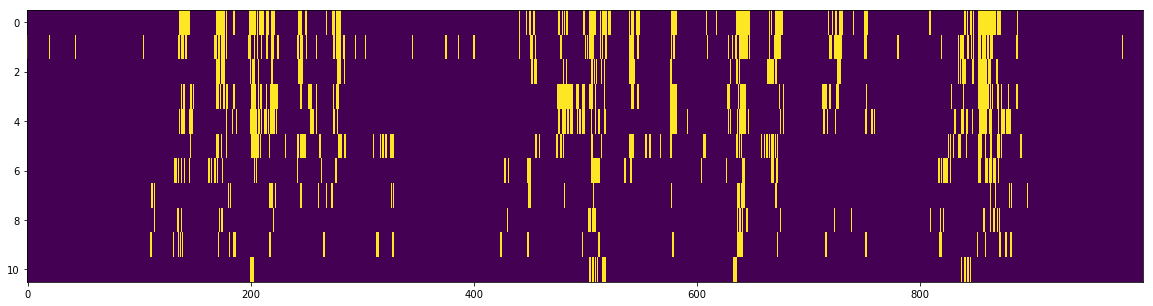

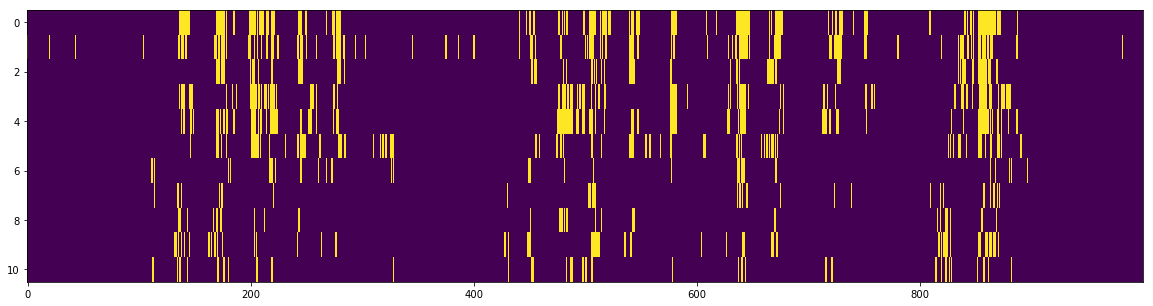

In [84]:
plt.figure(figsize=(20,5))
plt.imshow(loadmat("Ising/fRasters/fishN51R2P0F10S0.mat")["binnedSpikes"][:,:1000],aspect="auto")
plt.figure(figsize=(20,5))
plt.imshow(loadmat("Ising/fRasters/fishN51R3P0F10S0.mat")["binnedSpikes"][:,:1000],aspect="auto")

## Pipeline sobre RGC (no volver a ejecutar)

In [ ]:
#FULL RUN
if 1:
    for target in ordenadas: #High firing rate neurons
        continue
        dataset = datasetMaker(target,BASE)
        for f in Ns: #SELECTED
            name=filenameMkr(target,5,f,0,BASE) #MI
            saveRaster(name,[target]+dataset[name],1)
            runMatlab(name,0.00,0.00,1,0)
            modelCheck(name)
            _ = predictPSTH(RASTER[[target]+dataset[name]],loadParams(name),name,RASTER.shape[1],1)
            computeMeasuresPSTH(target,name,1)
            _ = predictPSTHperm(RASTER[[target]+dataset[name]],loadParams(name),name,RASTER.shape[1],1)
            computeMeasuresPSTH(target,name+"S",1)
    for target in ordenadas: #High firing rate neurons
        dataset = datasetMaker(target,BASE)
        for f in NsR: #RANDOM
            for s in range(5):
                name=filenameMkr(target,0,f,s,BASE) #RAND w/samples
                #print(name,modelView(name)[1:])
                saveRaster(name,[target]+dataset[name],1)
                runMatlab(name,0.00,0.00,1,1)
                modelCheck(name)
                _ = predictPSTH(RASTER[[target]+dataset[name]],loadParams(name),name,RASTER.shape[1],1)
                computeMeasuresPSTH(target,name,1)
                _ = predictPSTHperm(RASTER[[target]+dataset[name]],loadParams(name),name,RASTER.shape[1],1)
                computeMeasuresPSTH(target,name+"S",1)


Carga de archivo existente para neurona 215
(11, 31647)
(31647,)
(1507,)
11
(31647,)
(1507,)
(11, 31647)
Trying 0.05 0.05
(31647,)
(1507,)
11
(31647,)
(1507,)
(11, 31647)
Trying 0.05 0.05
(31647,)
(1507,)
11
(31647,)
(1507,)
(11, 31647)
Trying 0.05 0.05
(31647,)
(1507,)
11
(31647,)
(1507,)
(11, 31647)
Trying 0.05 0.05
(31647,)
(1507,)
11
(31647,)
(1507,)
(16, 31647)
Trying 0.05 0.05
(31647,)
(1507,)
16
(31647,)
(1507,)
(16, 31647)
Trying 0.05 0.05
(31647,)
(1507,)
16
(31647,)
(1507,)
(16, 31647)
(31647,)
(1507,)
16
(31647,)
(1507,)
(16, 31647)
Trying 0.05 0.05
(31647,)
(1507,)
16
(31647,)
(1507,)
(16, 31647)
Trying 0.05 0.05
(31647,)
(1507,)
16
(31647,)
(1507,)
(21, 31647)
Trying 0.05 0.05
(31647,)
(1507,)
21
(31647,)
(1507,)
(21, 31647)
Trying 0.05 0.05
(31647,)
(1507,)
21
(31647,)
(1507,)
(21, 31647)
Trying 0.05 0.05
(31647,)
(1507,)
21
(31647,)
(1507,)
(21, 31647)
(31647,)
(1507,)
21
(31647,)
(1507,)
(21, 31647)
Trying 0.05 0.05


In [134]:
name

'ratfieldN66R5P0F25S0'

In [91]:
RASTER.shape

(111, 59171)

In [34]:
# random repair
for target in ordenadas: #High firing rate neurons
        dataset = datasetMaker(target,BASE)
        for f in NsR: #RANDOM
            for s in range(5):
                name=filenameMkr(target,0,f,s,BASE) #RAND w/samples
                corref = modelView(name)[-1]
                print(name,corref,end="\t")
                new = 0
                while corref<0.9 or np.isnan(corref):
                    newsel = sorted(np.random.choice(np.array(list(set(range(N))-{target})),f,False).tolist())
                    dataset[name] = newsel
                    saveRaster(name,[target]+dataset[name],1)
                    runMatlab(name,0.001,0.001,1,1)
                    corref = modelView(name)[-1]
                    print(name,corref,end="\t")
                    new = 1
                if new:
                    overwriteDataset(target,dataset,BASE) #save updated values
                    predictPSTH(RASTER[[target]+dataset[name]],loadParams(name),name,RASTER.shape[1],1)
                    computeMeasures(target,name,1)
        print ("")
        

Carga de archivo existente para neurona 51
fishN51R0P0F10S0 1.0	fishN51R0P0F10S1 0.999	fishN51R0P0F10S2 0.999	fishN51R0P0F10S3 0.999	fishN51R0P0F10S4 1.0	fishN51R0P0F15S0 0.98	fishN51R0P0F15S1 0.999	fishN51R0P0F15S2 0.999	fishN51R0P0F15S3 0.988	fishN51R0P0F15S4 1.0	fishN51R0P0F20S0 0.997	fishN51R0P0F20S1 0.947	fishN51R0P0F20S2 0.999	fishN51R0P0F20S3 0.913	fishN51R0P0F20S4 0.999	fishN51R0P0F25S0 0.986	fishN51R0P0F25S1 0.916	fishN51R0P0F25S2 0.993	fishN51R0P0F25S3 0.948	fishN51R0P0F25S4 0.91	
Carga de archivo existente para neurona 33
fishN33R0P0F10S0 0.999	fishN33R0P0F10S1 0.999	fishN33R0P0F10S2 1.0	fishN33R0P0F10S3 1.0	fishN33R0P0F10S4 0.999	fishN33R0P0F15S0 0.999	fishN33R0P0F15S1 0.999	fishN33R0P0F15S2 0.999	fishN33R0P0F15S3 0.999	fishN33R0P0F15S4 0.999	fishN33R0P0F20S0 0.999	fishN33R0P0F20S1 0.923	fishN33R0P0F20S2 0.999	fishN33R0P0F20S3 0.999	fishN33R0P0F20S4 0.999	fishN33R0P0F25S0 0.993	fishN33R0P0F25S1 0.999	fishN33R0P0F25S2 0.911	fishN33R0P0F25S3 0.908	fishN33R0P0F25S4 0.987	
Carg

## Plot mean($R^2$)

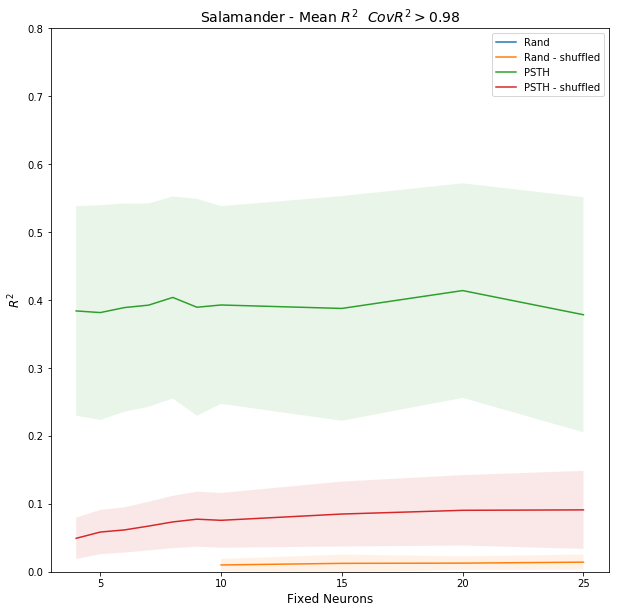

In [69]:
overallR2(ordenadas,0.98)
# ambos criterios de seleccion-- + agregar MI

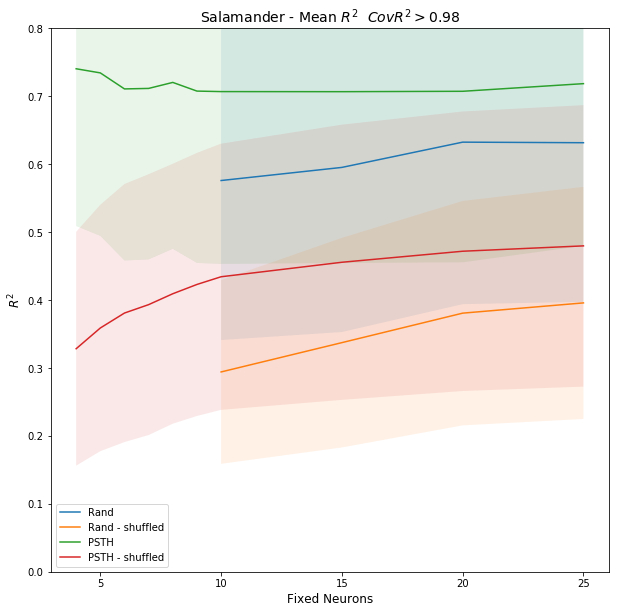

In [145]:
overallR2(ordenadas,0.98)

In [70]:
asd

NameError: name 'asd' is not defined

In [224]:
dataset = datasetMaker(51,BASE)
sorted(enumerate(D[51]),key=lambda x:x[1])[:5]

Carga de archivo existente para neurona 51


[(51, 0.0), (141, 511.04), (91, 588.26), (21, 597.56), (19, 603.96)]

In [231]:
for n in Ns:
    misel = set(dataset["fishN51R2P0F{}S0".format(n)])
    thsel = set(dataset["fishN51R5P0F{}S0".format(n)])
    print(n,round(len(misel&thsel)/n*100))
#print(dataset["fishN51R3P0F10S0"])
#print(dataset["fishN51R2P0F10S0"])
#print(dataset["fishN51R5P0F10S0"])


4 100
5 100
6 83
7 71
8 88
9 89
10 80
15 80
20 85
25 84


## Plots interactivos

In [24]:
@interact_manual(nr=NsR,nmi=Ns)
def violins(nr,nmi):
    randr2,mir2 = [computeMeasures(target,filenameMkr(target,0,nr,0,BASE)) for target in ordenadas],[computeMeasures(target,filenameMkr(target,2,nmi,0,BASE)) for target in ordenadas]
    plt.figure(figsize=(12,8))
    plt.title("$R^2$ distribution and correspondence")
    plt.violinplot([randr2,mir2])
    plt.ylabel("$R^2$")
    plt.xticks([1,2],["Rand {}".format(nr),"MI {}".format(nmi)])
    for n in range(len(randr2)):
        plt.plot([1,2],[randr2[n],mir2[n]],alpha=0.05,c="black")
    plt.show()

interactive(children=(Dropdown(description='nr', options=(10, 15, 20, 25), value=10), Dropdown(description='nm…

In [74]:
def modelEval(target,filename):
    modelView(filename,1)
    showPredictionPSTH(target,filename)

@interact_manual(target=ordenadas,r=[0,5],f=NsR,s=range(5))
def metaModelEval(target,r,f,s):
    name=filenameMkr(target,r,f,s,BASE)
    modelEval(target,name)
    #plotr2(target)

interactive(children=(Dropdown(description='target', options=(215, 113, 14, 58, 28, 19, 35, 82, 229, 83, 41, 5…

In [149]:
vA = np.linspace(1,10,100)
vB = np.random.random(100)*5+vA

In [152]:
np.corrcoef(vA,vB*100)

array([[1.        , 0.84473003],
       [0.84473003, 1.        ]])

## Violinplots Correlacion media, covarianza y r2

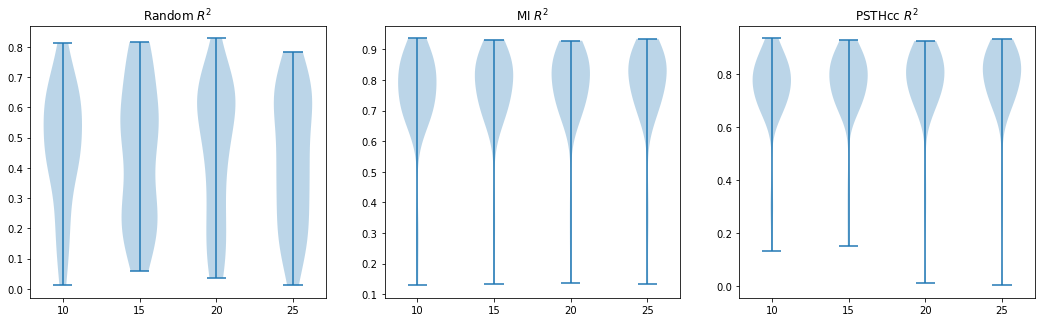

/opt/miniconda/envs/jupyterhub/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


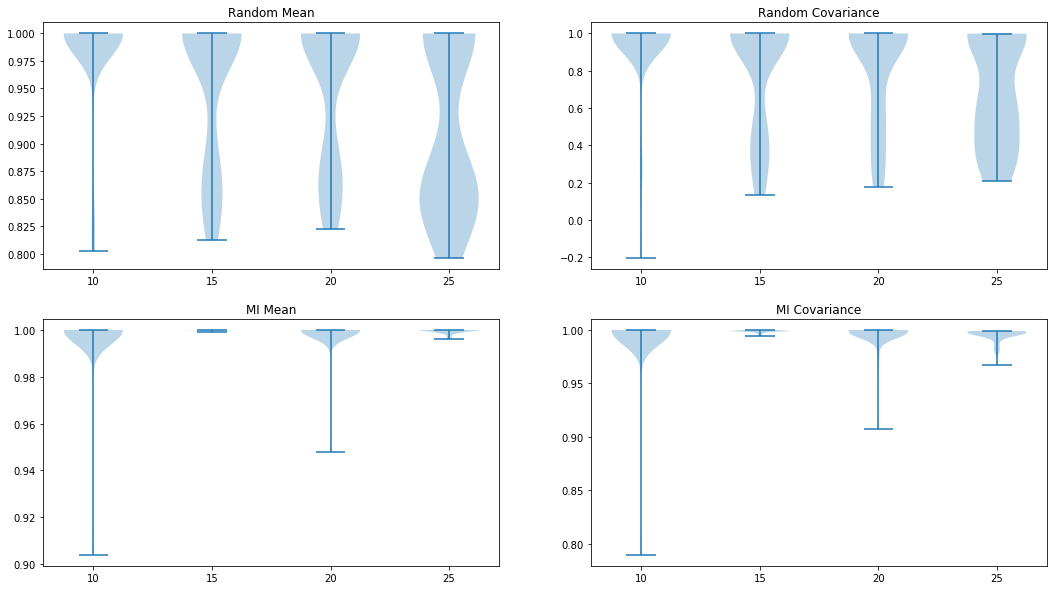

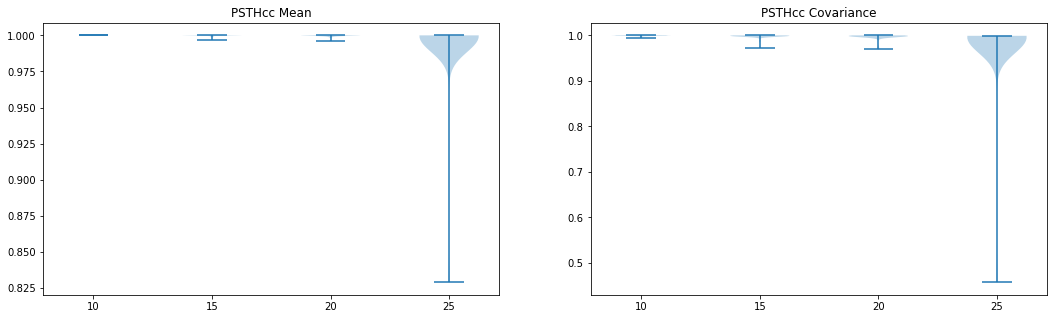

In [16]:
fxs = [10,15,20,25]
xaxis = range(1,len(fxs)+1)
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.title("Random $R^2$")
plt.violinplot([[computeMeasures(target,filenameMkr(target,0,nn,0,BASE)) for target in ordenadas] for nn in fxs])
plt.xticks(xaxis,fxs)
plt.subplot(1,3,2)
plt.title("MI $R^2$")
plt.violinplot([[computeMeasures(target,filenameMkr(target,2,nn,0,BASE)) for target in ordenadas] for nn in fxs])
plt.xticks(xaxis,fxs)
plt.subplot(1,3,3)
plt.title("PSTHcc $R^2$")
plt.violinplot([[computeMeasures(target,filenameMkr(target,5,nn,0,BASE)) for target in ordenadas] for nn in fxs])
plt.xticks(xaxis,fxs)
plt.show()
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
plt.title("Random Mean")
plt.violinplot([[modelView(filenameMkr(target,0,nn,0,BASE),0)[1] for target in ordenadas if not np.isnan(modelView(filenameMkr(target,0,nn,0,BASE),0)[1])] for nn in fxs])
plt.xticks(xaxis,fxs)
plt.subplot(2,2,2)
plt.title("Random Covariance")
plt.violinplot([[modelView(filenameMkr(target,0,nn,0,BASE),0)[2] for target in ordenadas if not np.isnan(modelView(filenameMkr(target,0,nn,0,BASE),0)[2])] for nn in fxs])
plt.xticks(xaxis,fxs)
plt.subplot(2,2,3)
plt.title("MI Mean")
plt.violinplot([[modelView(filenameMkr(target,2,nn,0,BASE),0)[1] for target in ordenadas if not np.isnan(modelView(filenameMkr(target,2,nn,0,BASE),0)[1])] for nn in fxs])
plt.xticks(xaxis,fxs)
plt.subplot(2,2,4)
plt.title("MI Covariance")
plt.violinplot([[modelView(filenameMkr(target,2,nn,0,BASE),0)[2] for target in ordenadas if not np.isnan(modelView(filenameMkr(target,2,nn,0,BASE),0)[2])] for nn in fxs])
plt.xticks(xaxis,fxs)
plt.show()
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.title("PSTHcc Mean")
plt.violinplot([[modelView(filenameMkr(target,5,nn,0,BASE),0)[1] for target in ordenadas if not np.isnan(modelView(filenameMkr(target,5,nn,0,BASE),0)[1])] for nn in fxs])
plt.xticks(xaxis,fxs)
plt.subplot(1,2,2)
plt.title("PSTHcc Covariance")
plt.violinplot([[modelView(filenameMkr(target,5,nn,0,BASE),0)[2] for target in ordenadas if not np.isnan(modelView(filenameMkr(target,5,nn,0,BASE),0)[2])] for nn in fxs])
plt.xticks(xaxis,fxs)
plt.show()

## Varios

In [ ]:
#computeMeasures(51,"fishN51R2P0F20S0")
#def runall(target,r,f,s,)
plotr2(141)
plotr2(91)
plotr2(16)
plotr2(45)

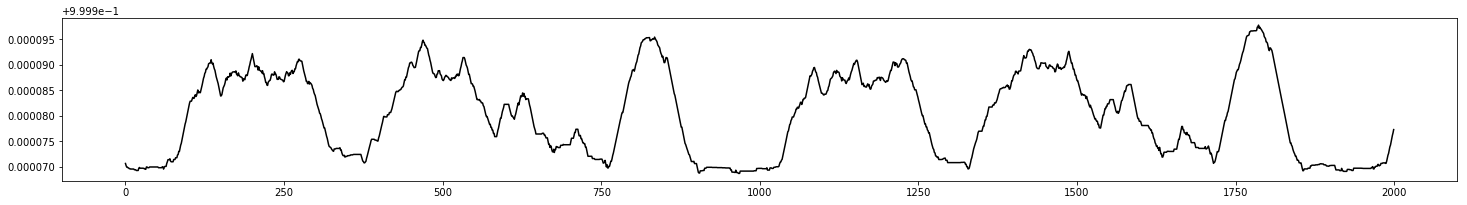

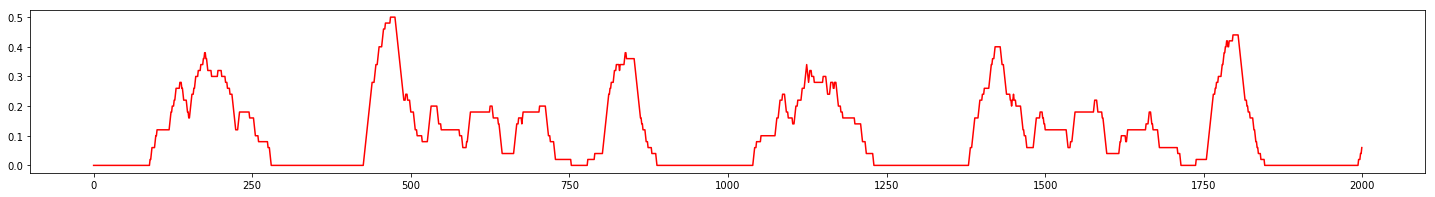

In [45]:
plt.figure(figsize=(25,3))
plt.plot(range(2000),(getPrediction("fishN19R0P0F30S0")[:2000]),c="k")
plt.show()
plt.figure(figsize=(25,3))
plt.plot(range(2000),SPRATE[19][:2000],c="r")
plt.show()

In [46]:
getPrediction("fishN19R0P0F30S0")[:5000][:10]

array([0.99997065, 0.99997021, 0.99996993, 0.99996993, 0.9999698 ,
       0.99996976, 0.99996962, 0.99996962, 0.99996956, 0.99996956])

In [40]:
allR2 = dict([(filenameMkr(target,0,nn,ss,BASE),computeMeasures(target,filenameMkr(target,0,nn,ss,BASE))) for target in ordenadas for nn in NsR for range(5)]+[(filenameMkr(target,2,nn,0,BASE),computeMeasures(target,filenameMkr(target,2,nn,0,BASE))) for target in ordenadas for nn in Ns])
allModels = dict([(filenameMkr(target,0,nn,ss,BASE),modelView(filenameMkr(target,0,nn,ss,BASE))[1:]) for target in ordenadas for nn in NsR for range(5)]+[(filenameMkr(target,2,nn,0,BASE),modelView(filenameMkr(target,2,nn,0,BASE))[1:]) for target in ordenadas for nn in Ns])

SyntaxError: invalid syntax (<ipython-input-40-1c3df3910f50>, line 1)

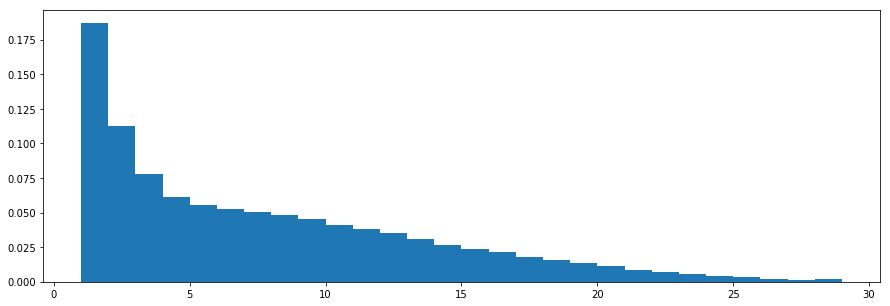

In [56]:
plt.figure(figsize=(15,5))
bars,vals,_ = plt.hist(np.sum(RASTER,axis=0),bins=range(1,30),normed=1)

In [61]:
sum(bars[9:])

0.30944730509135393

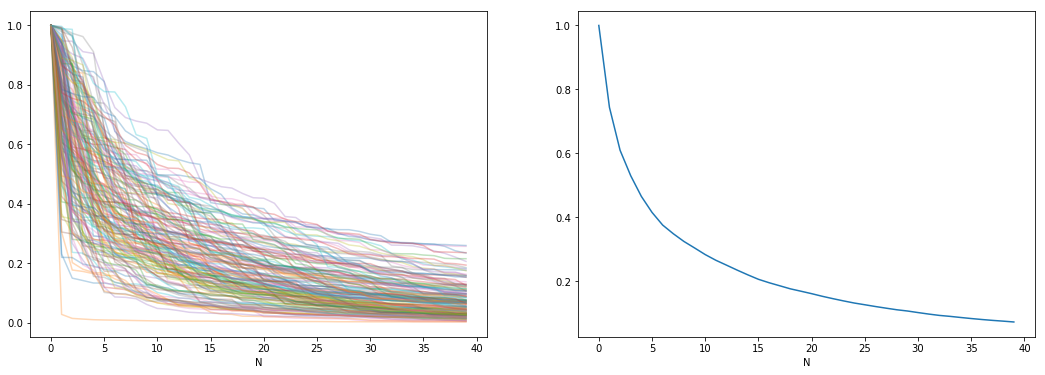

In [130]:
fig,ax = plt.subplots(1,2,figsize=(18,6))
for n in range(RASTER.shape[0]):
    ax[0].plot(np.sort(CC[n]/max(CC[n]))[::-1][:40],alpha=0.3)
    ax[0].set_xlabel("N")
ax[1].plot(np.mean(np.vstack([np.sort(CC[n]/max(CC[n]))[::-1][:40] for n in range(RASTER.shape[0])]),axis=0))
ax[1].set_xlabel("N")
plt.show()

In [171]:
reRASTER = loadmat("../Data/Fishmovie/IST-2017-61-v1+1_bint_fishmovie32_100.mat")["bint"]
SINGLERASTER = np.sum(reRASTER,axis=0)

In [74]:
singleSP = spRate(SINGLERASTER[51]/297)

In [73]:
SPRATE.shape

(160, 282991)

In [76]:
np.corrcoef(SPRATE[51][:len(singleSP)],list(singleSP))

array([[1.        , 0.98849402],
       [0.98849402, 1.        ]])

In [60]:
def spRate(array):
    return (np.array([np.sum(array[i:i+50]) for i in range(0,array.shape[0]-50)])/50).T

In [24]:
D = np.zeros((160,160))
for x in range(160):
    for y in range(160):
        D[x][y]= np.sum(np.abs(SINGLERASTER[x]/50-SINGLERASTER[y]/50))

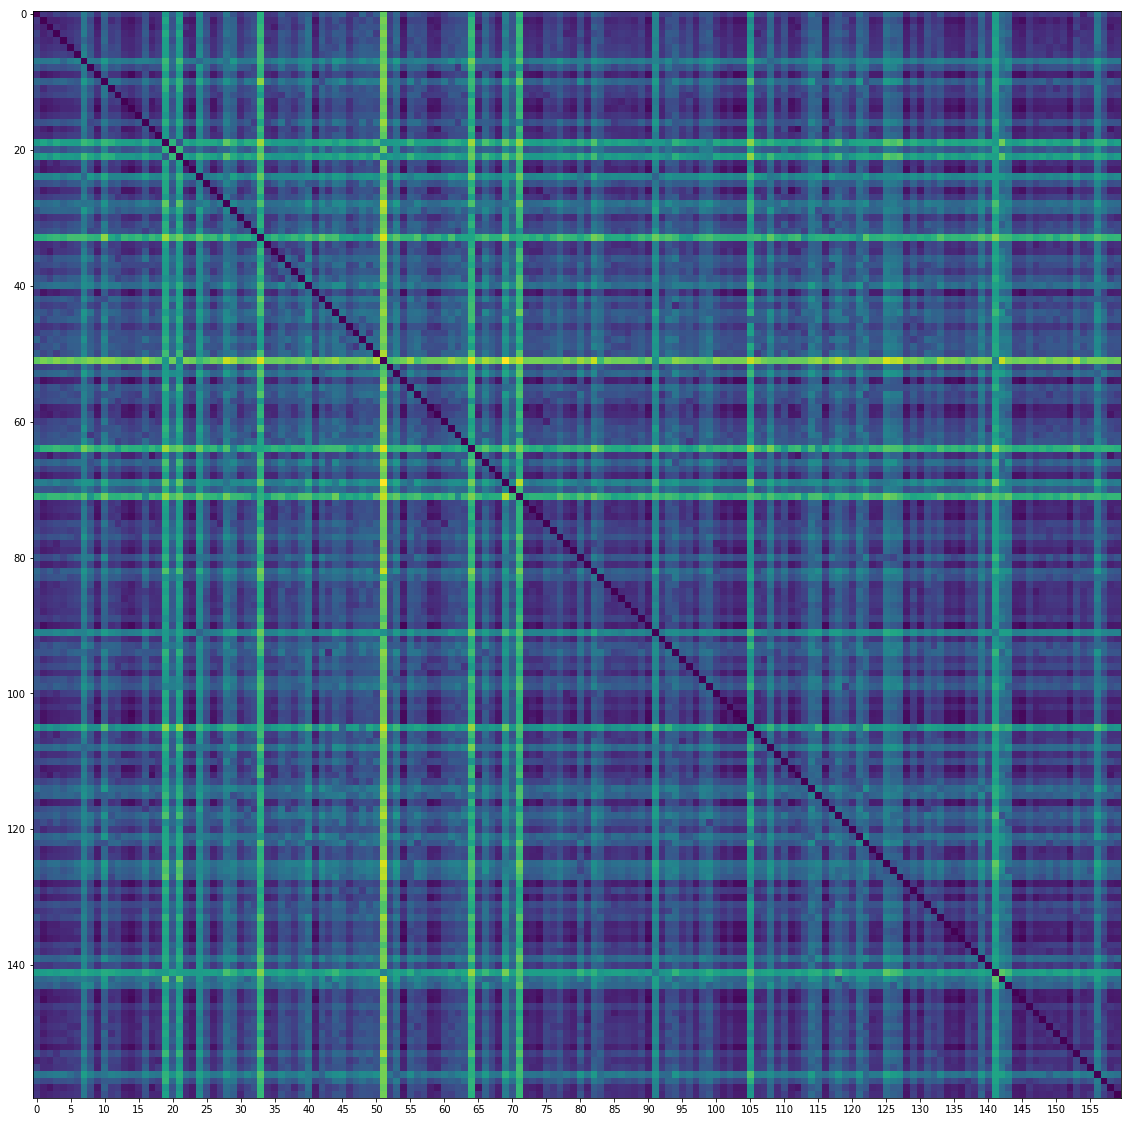

In [25]:
plt.figure(figsize=(20,20))
plt.xticks(range(0,160,5))
plt.imshow(D)

In [92]:
nn = 51
print(sorted(enumerate(D[nn]),key=lambda x:x[1])[:5])
print(sorted(enumerate(MI[nn]),key=lambda x:x[1],reverse=1)[:5])
print(sorted(enumerate(CC[nn]),key=lambda x:x[1],reverse=1)[:5])

[(51, 0.0), (141, 511.04), (91, 588.26), (21, 597.56), (19, 603.96)]
[(141, 0.12141658833002075), (91, 0.10434591490074419), (19, 0.10425425064759758), (21, 0.10242641591066706), (24, 0.04618494520973227)]
[(141, 0.2294148564250973), (91, 0.20338079758324543), (19, 0.19467177253597812), (21, 0.19249108825872713), (24, 0.08407722251273991)]


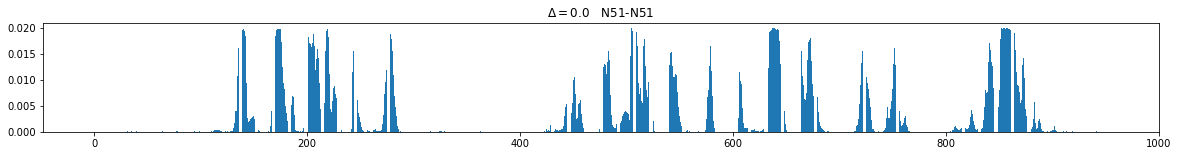

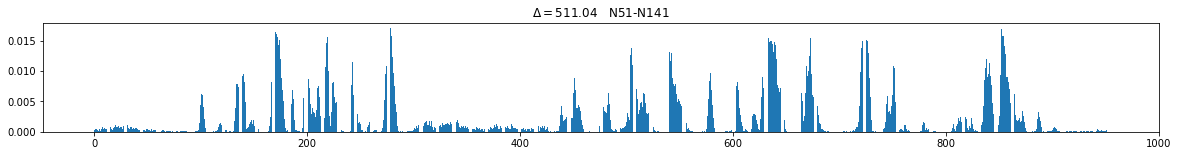

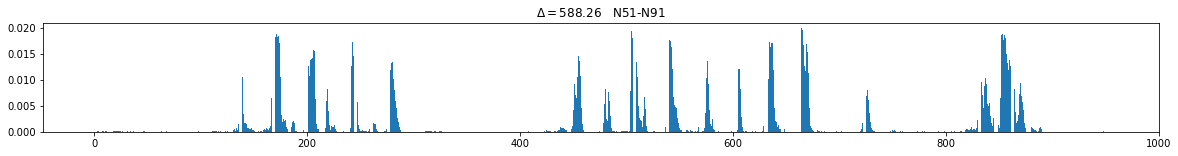

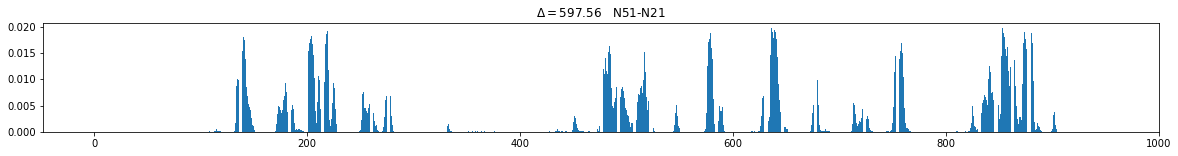

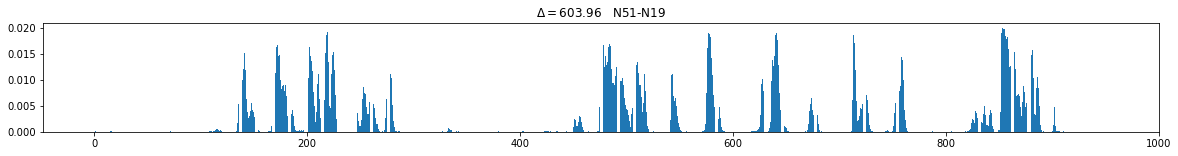

In [140]:
nn = 51
for n,_ in sorted(enumerate(D[nn]),key=lambda x:x[1])[:5]:
    plt.figure(figsize=(20,2))
    plt.bar(range(953),SINGLERASTER[n]/297/50) #/ITERS / 0.02
    plt.title("$\Delta={}$   N{}-N{}".format(np.round(np.sum(np.abs(SINGLERASTER[51]/50-SINGLERASTER[n]/50)),3),nn,n))
    plt.show()

In [193]:
psthE = np.sum(reRASTER[::2,:,:],axis=0)/149
psthO = np.sum(reRASTER[1::2,:,:],axis=0)/148
nsimilarity = [np.corrcoef(psthE[n],psthO[n])[0,1] for n in range(160)]

In [194]:
def stability(n):
    plt.figure(figsize=(10,10))
    plt.scatter(psthE[n],psthO[n])
    plt.title(np.round(np.corrcoef(psthE[n]/149/50,psthO[n]/148/50)[0,1],3))
    plt.show()
interact(stability,n=(1,160))

interactive(children=(IntSlider(value=80, description='n', max=160, min=1), Output()), _dom_classes=('widget-i…

<function __main__.stability(n)>

In [180]:
list(map(lambda x:x.shape,[psthE,psthO]))

[(160, 953), (160, 953)]

In [38]:
sorted([(x[1],x[0]) for x in enumerate(Dcc[51])],reverse=1)[:5]

[(1.0, 51),
 (0.8411652351202552, 141),
 (0.7048074069561335, 91),
 (0.6997420087325282, 19),
 (0.6774407778164653, 21)]